202311_jedha_bloc3_ChallengeML
Beraud Mélanie

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !


# Import libraries

In [142]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from plotly.subplots import make_subplots
# Ma palette pour les plotly
pio.templates["mel_purple"] = go.layout.Template(
    layout_colorway=['#FF34B3', '#CD2990', '#8B1C62', '#CD00CD', '#8B008B', '#8968CD', '#5D478B','#20B2AA']) #'#EEA2AD', trop proche

pio.templates.default = "mel_purple"
pio.renderers.default = 'notebook_connected' # to be replaced by "iframe_connected" to have the pictures in files

from IPython.display import display

# Functions

In [143]:
# Preprocessing function:
def prepare_datasets(donnees, name_dataset):

    ''' 
    Should be given:
    * data to process
    * name for the dataset in ''
    The function will prepare Features X/Target Y datatsets, train/val subsets: Splitting and Preprocessing
    And return (in that order):
        * 4 preprocessed datasets (X_train, X_val, y_train, y_val) 
        * list of names for num features, cat features from input dataset
        * name of X_train/X_val columns
        * the name of the dataset for log
    '''
    name_dataset = name_dataset

    X = donnees.drop('converted', axis = 1)
    Y = donnees.loc[:, 'converted']
    print(type(X), X.shape, type(Y), Y.shape)

    # Train_val split
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
    #X_train[0:5], y_val[0:5]

    # Recovery features category_name
    num_features = []
    cat_features = []

    for col in X_train:
        if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
            num_features.append(col)
        else:
            cat_features.append(col)

    num_features = num_features
    print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

    # Preprocessings
    norm = StandardScaler()
    encod = OneHotEncoder(drop="first")

    preprocesseur = ColumnTransformer(transformers=[
    ('num', norm, num_features),
    ('cat', encod, cat_features)])
    
    X_train = preprocesseur.fit_transform(X_train)
    X_val = preprocesseur.transform(X_val)

    # recovery of columns names in X_train and X_val
    liste_features_name = []    
    for name in preprocesseur.get_feature_names_out():
        liste_features_name.append(name[5:])
    #print(liste_features_name, liste_features_name[0], liste_features_name[1])

    print (f'Dataset {name_dataset} is ready.')

    return X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset
    #X_train[0:5], y_train[0:5], X_val[0:5], y_val[0:5], y_train.value_counts(), y_val.value_counts()

# X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full')

def model_scores(name_model, model, name_dataset = name_dataset):

    name_model = name_model
    name_dataset = name_dataset
    model = model

    # Predictions

    y_train_pred = model.predict(X_train)
    y_val_pred = classifier.predict(X_val)

    #scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_val = classifier.score(X_val, y_val)

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)


    parametres = model.get_params()
    coefficients = [coef for coef in classifier.coef_]

    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)

    print('classification report train')
    print(report_train)
    print('classification report val')
    print(report_val)

    # Confusion matrix
    tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
    fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

    tn_train, fp_train = confusion_matrix(y_train, y_train_pred)[0,0], confusion_matrix(y_train, y_train_pred)[0,1]
    fn_train, tp_train = confusion_matrix(y_train, y_train_pred)[1,0], confusion_matrix(y_train, y_train_pred)[1,1]
    
    #tn_val, fp_val, fn_val, tp_val

    #Confusion matrix    
    print('matrices de confusion')
    fig_train , ax1 = plt.subplots()
    ax1.set(title="Confusion Matrix on Train set") 
    ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax1) 
    fig_train.show('notebook_connected')

    fig_val , ax2 = plt.subplots()
    ax2.set(title="Confusion Matrix on val set") 
    ConfusionMatrixDisplay.from_estimator(classifier, X_val, y_val, ax=ax2) 
    fig_val.show() 

    report = [name_model, model, name_dataset,  parametres, 
              accuracy_train, accuracy_val, coefficients, 
              y_train_pred, y_val_pred, f1_train, f1_val, 
              tn_val, fp_val, fn_val, tp_val,
              tn_train, fp_train, fn_train, tp_train,
              report_train, report_val]

    

    dataf  = pd.DataFrame(data=[], columns = ['name_model', 'model', 'name_dataset',  'parametres', 
              'accuracy_train', 'accuracy_val', 'coefficients', 
              'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 
              'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train',
              'report_train', 'report_val'])
    

    
    print(f'Report will be composed of :\n {[col for col in dataf.columns]}')
    
    dataf.loc[len(test), :] = report
    '''

    return model, type_model, name_dataset, parametres,\
          accuracy_train, accuracy_val, coefficients,\
              y_train_pred, y_val_pred, f1_train, f1_val,\
                  tn_val, fp_val, fn_val, tp_val,\
                     tn_train, fp_train, fn_train, tp_train,\
                          report
  
    # classifier.get_params().__getitem__('C')

    coeff= pd.DataFrame(test['coefficients'][0])
    coeff
    '''
    # presentation
    liste_scores = ['name_model', 'model', 'name_dataset', 'accuracy_train', 'accuracy_val', 'f1_train', 'f1_val']
    liste_confusionMatrix = ['name_model', 'model', 'name_dataset', 'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train']
    liste_params = ['name_model', 'model', 'name_dataset',  'parametres', 'coefficients']
    
    '''
        ['name_model', 'model', 'name_dataset',  'parametres', 
                'accuracy_train', 'accuracy_val', 'coefficients', 
                'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 
                'tn_val', 'fp_val', 'fn_val', 'tp_val',
                'tn_train', 'fp_train', 'fn_train', 'tp_train',
                'report_train', 'report_val']
    '''
    scores = dataf.loc[:, liste_scores]
    confusion = dataf.loc[:, liste_confusionMatrix]
    parametre = dataf.loc[:, liste_params]
    # adapter les parametre selon le type de modèle... et les coeff selon le nb de coeff


    display(scores, confusion, parametre)


    
    return dataf #, scores

#resultats_model = model_scores('name_model', model, name_dataset = name_dataset)



# Import data

In [144]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB


In [5]:
data.head()

'''
data.columns
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [15]:
data.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.0,284580,284580.000000,284580.000000
unique,4,NaN,2.0,3,NaN,NaN
top,US,NaN,1.0,Seo,NaN,NaN
freq,160124,NaN,195066.0,139477,NaN,NaN
mean,NaN,30.564203,NaN,NaN,4.873252,0.032258
std,NaN,8.266789,NaN,NaN,3.341995,0.176685
min,NaN,17.000000,NaN,NaN,1.000000,0.000000
25%,NaN,24.000000,NaN,NaN,2.000000,0.000000
50%,NaN,30.000000,NaN,NaN,4.000000,0.000000
75%,NaN,36.000000,NaN,NaN,7.000000,0.000000


In [ ]:
# No need anymore ...

data.info() # No Null values
data.new_user.astype('category')
data.info()

for col in data.columns:
    print(col, data[col].value_counts(dropna=False))

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

# EDA

In [72]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.new_user = data_sample.new_user.astype('category')
data_sample.dtypes

#TO WORK without importing dataset
data_sample.to_csv('data_sample.csv') 

In [73]:
data_sample.new_user.value_counts(dropna=False)

new_user
1    6922
0    3078
Name: count, dtype: int64

In [28]:
data_sample = pd.read_csv('data_sample.csv', index_col=0)
data_sample.new_user = data.new_user.astype('category')

'''
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

data_sample.info()

# recovery of num features and cat features
num_features = []
cat_features = []

for col in data_sample:
    if data_sample[col].dtypes == 'int64' or data_sample[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features[:-1]
num_features, cat_features

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 179667 to 275284
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   country              10000 non-null  object  
 1   age                  10000 non-null  int64   
 2   new_user             10000 non-null  category
 3   source               10000 non-null  object  
 4   total_pages_visited  10000 non-null  int64   
 5   converted            10000 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 478.6+ KB


(['age', 'total_pages_visited'], ['country', 'new_user', 'source'])

In [79]:
data_sample.new_user.value_counts(dropna=False)

new_user
1    6922
0    3078
Name: count, dtype: int64

In [ ]:
# Pairwise dependencies _ no need here
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [76]:
data_sample.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.0,10000,10000.000000,10000.000000
unique,4,NaN,2.0,3,NaN,NaN
top,US,NaN,1.0,Seo,NaN,NaN
freq,5600,NaN,6922.0,4840,NaN,NaN
mean,NaN,30.616500,NaN,NaN,4.782500,0.028300
std,NaN,8.352641,NaN,NaN,3.221216,0.165837
min,NaN,17.000000,NaN,NaN,1.000000,0.000000
25%,NaN,24.000000,NaN,NaN,2.000000,0.000000
50%,NaN,30.000000,NaN,NaN,4.000000,0.000000
75%,NaN,36.000000,NaN,NaN,6.000000,0.000000


In [77]:
data_sample.new_user.value_counts(dropna=False)


new_user
1    6922
0    3078
Name: count, dtype: int64

In [ ]:

''' Nope... sert à en mettre plusieurs à côté
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for axi in ax.flatten():  # enumerate - 0 pour histogramme et 1 box
    axi.hist(data_sample[col])
'''

for col in num_features:
    fig = make_subplots(rows = 1, cols = 2)#, figsize=[10,20])

    fig.add_trace(px.histogram(data_sample[col]).data[0], row = 1, col=1)
    fig.add_trace(px.box(data_sample[col]).data[0], row = 1, col=2)
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    #fig.show('iframe_connected') #only the last one :()
    display(fig)

   
    # ne fonctionne pas avec fig, axs & ax[0], ou ax[0,0], ne fonctionne pas avec fig, '(ax1, ax2) et ax1= 


for col in cat_features:
    fig = px.histogram(data_sample[col], title=f'Distribution {col}')
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    display(fig)




In [ ]:
data.age.mean(), data.age.max()
fig = px.histogram(data.age)

fig = px.histogram(data.age[data['age']>60])
display(fig)
fig.show('iframe_connected')
# Garder en tête : Il y a des ousiders en age : 110 et 120 ans

### Garder en tête : Il y a des ousiders en age : 110 et 120 ans. Record reconnu de tous les ltemps : Jeanne Calmant 121 ans.

In [14]:
# useless  on only 2 num_features...
temp = data.loc[:,num_features]
corr_matrix = temp.corr().round(2)

corr_matrix


,age,total_pages_visited
age,1.00,-0.05
total_pages_visited,-0.05,1.00


In [ ]:
# doesn't work

'''
import ipywidgets as ipw

VBox([HBox([fw1, fw2]), HBox([fw3])])
'''

fig2 = make_subplots(rows = 1, cols = 3) # doesnt' work

for col in cat_features:
    
    #gra = px.histogram(data_sample[col], title=f'Distribution {col}')
    #fig2.get_subplot(row = 1, col = 1, subplots = gra)
    #fig2 =  ipw.HBox([gra])                  
    fig2.add_traces(px.histogram(data_sample[col]), rows = 0, cols =1)#, title=f'Distribution {col}')
    #update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
#                    showlegend=False, width=800, height =400)
fig2.show()

### Preprocessing before separation :
No NaN, encoding cat = ok
### Preprocessing after separation:
OneHotEncoder for 3 cat, norm for 2 num

# First model

In [22]:
num_features, cat_features

([], ['country'])

In [ ]:
print(X_train.age[0:5], X_val.age[0:5], X_train.columns, X_val.columns)

# Preprocessings
norm = StandardScaler()
encod = OneHotEncoder(drop="first")

preprocesseur = ColumnTransformer(transformers=[
('num', norm, num_features),
('cat', encod, cat_features)])

X_train = preprocesseur.fit_transform(X_train)
X_val = preprocesseur.transform(X_val)

print(X_train[0:5], X_val[0:5]) # ok

In [ ]:

corr_matrix = X.corr().round(2) # doesn't work
#import plotly.figure_factory as ff
'''
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()
temp = corr(data)
'''
corr_matrix


In [218]:
liste_features_name = []
'''
array(['num__age', 'num__total_pages_visited', 'cat__country_China',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__new_user_0', 'cat__new_user_1', 'cat__source_Ads',
       'cat__source_Direct', 'cat__source_Seo'], dtype=object)
'''
for name in preprocesseur.get_feature_names_out():
       liste_features_name.append(name[5:])

liste_features_name, liste_features_name[0], liste_features_name[1]


(['age',
  'total_pages_visited',
  'country_Germany',
  'country_UK',
  'country_US',
  'new_user_1',
  'source_Direct',
  'source_Seo'],
 'age',
 'total_pages_visited')

In [ ]:
train_sample = pd.DataFrame(X_train[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
val_sample = pd.DataFrame(X_val[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
#val_sample.head()

print(train_sample.shape, val_sample.shape)


fig = make_subplots(rows = 1, cols = 4)#, figsize=[10,20])

fig.add_trace(px.histogram(train_sample[liste_features_name[0]]).data[0], row = 1, col=1)
fig.add_trace(px.histogram(train_sample[liste_features_name[1]]).data[0], row = 1, col=2)
fig.add_trace(px.histogram(val_sample[liste_features_name[0]]).data[0], row = 1, col=3)
fig.add_trace(px.histogram(val_sample[liste_features_name[1]]).data[0], row = 1, col=4)
fig.update_layout(showlegend=False, width=1200, height =400)


display(fig)


# Data

### Datasets

### Splitting, Preprocessing
using the prepare_datasets function

X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'name_dataset') 

In [145]:
X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full') 


# it works with only one column ! data = data.loc[:,['converted', 'age']] Trop cool !

<class 'pandas.core.frame.DataFrame'> (284580, 5) <class 'pandas.core.series.Series'> (284580,)
num_features are:['age', 'total_pages_visited'],
cat_features are:['country', 'new_user', 'source']
Dataset full is ready.


# Models

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.77      7344

    accuracy                           0.99    227664
   macro avg       0.92      0.84      0.88    227664
weighted avg       0.99      0.99      0.99    227664

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.68      0.76      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.87     56916
weighted avg       0.98      0.99      0.99     56916

matrices de confusion
Report will be composed of :
 ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_trai

/tmp/ipykernel_7819/3863517468.py:106: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_7819/3863517468.py:111: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
1,reglog_full,LogisticRegression(),full,0.986331,0.985769,0.765451,0.755435


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
1,reglog_full,LogisticRegression(),full,54855,225,585,1251,219474,846,2266,5078


,name_model,model,name_dataset,parametres,coefficients
1,reglog_full,LogisticRegression(),full,"{'C': 1.0, 'class_weight': None, 'dual': False...","[[-0.5942006647998186, 2.548630474171293, 3.57..."


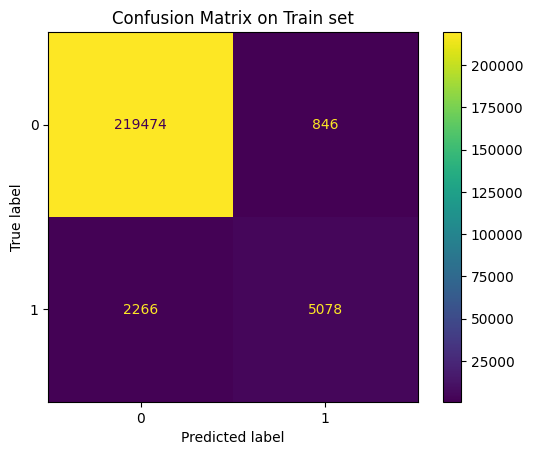

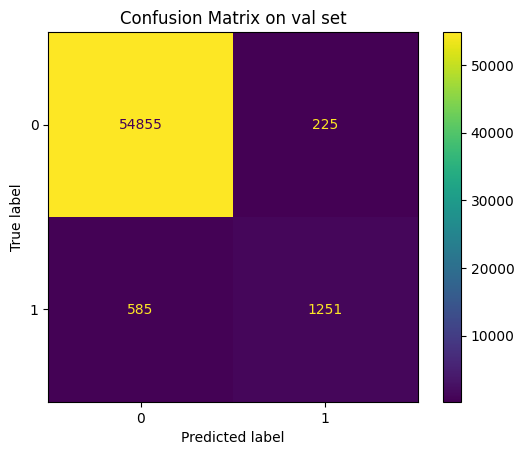

In [146]:
classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

#list_params = classifier.get_params()
#print(list_params)

resultats_reglog_full = model_scores('reglog_full', classifier, name_dataset = name_dataset)


## Training pipeline

In [33]:
# First model

classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

list_params = classifier.get_params()
print(list_params)

classifier.score(X_train, y_train)
print(f"\nX_train accuracy:{classifier.score(X_train, y_train)},\n\
X_val accuracy:{classifier.score(X_val, y_val)}\n")

# Predictions & F1
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

print(f'X_train F1:{f1_score(y_train, y_train_pred)},\n\
X_val F1:{f1_score(y_val,y_val_pred)}')

# coeff importance:
print('Features_importance:')
feat_imp = pd.DataFrame([coef for coef in classifier.coef_], columns=liste_features_name)
feat_imp

temp = feat_imp.transpose()
fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
fig.update_yaxes(title = None)
fig.show()

# Confusion matrix

tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

#tn_val, fp_val, fn_val, tp_val

print('Confusion Matrix:')
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_val, y_val, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()


{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

X_train accuracy:0.9863307330100499,
X_val accuracy:0.9857685009487666

X_train F1:0.7654507084715104,
X_val F1:0.7554347826086957
Features_importance:


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:

classification_report

from sklearn.tree import plot_tree

class_names = encoder.inverse_transform([0, 1, 2])

plt.figure(figsize=(20,20))
a = plot_tree(classifier_gini, 
              feature_names=X.columns, 
              class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)

### Most important features 
seems to be The number of pages visited (positive correlation) and the country, the new user variable
Impact of sources is not that important, age neither.

### scores
F1 and accracy scores are basically the same for train and test

### Confusion matrice:
30% errors ont the positives labels (30% have been predicted as negative)
15% predicted neg should be true.

We need to work on the 30% errors...
Try with a gradient ?



In [3]:
# Fonction doesn't work

#classifier = LogisticRegression() # 
#classifier.fit(X_train, y_train)

def model_pipeline(model_type, model_name):
    
    model = model_name

    model_name = model_type 
    classifier.fit(X_train, y_train)

    model.fit(X_train, y_train)

    list_params = classifier.get_params()
    print(list_params)

    classifier.score(X_train, y_train)
    print(f"\nX_train accuracy:{classifier.score(X_train, y_train)},\n\
    X_val accuracy:{classifier.score(X_val, y_val)}\n")

    # Predictions & F1
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)

    print(f'X_train F1:{f1_score(y_train, y_train_pred)},\n\
    X_val F1:{f1_score(y_val,y_val_pred)}')

    # coeff importance:
    print('Features_importance:')
    feat_imp = pd.DataFrame([coef for coef in classifier.coef_], columns=liste_features_name)
    feat_imp

    temp = feat_imp.transpose()
    fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
    fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
    fig.update_yaxes(title = None)
    fig.show()

    # Confusion matrix
    print('Confusion Matrix:')
    _ , ax = plt.subplots() # Get subplot from matplotlib
    ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
    plt.show()

    _ , ax = plt.subplots() # Get subplot from matplotlib
    ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(classifier, X_val, y_val, ax=ax) # ConfusionMatrixDisplay from sklearn
    plt.show()

model_pipeline(LogisticRegression(), classifier)

NameError: name 'LogisticRegression' is not defined

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**